# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [9]:
# Load pickled data
import pickle
import numpy as np

training_file = '/home/ubuntu/traffic-signs/train.p'
testing_file = '/home/ubuntu/traffic-signs/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

original_y_train = y_train
setOfLabels = set(y_train)
X_train_mean = np.mean(X_train)

# Free up memory
del train  
del test

In [10]:
from sklearn.preprocessing import LabelBinarizer
import numpy as np

# Turn labels into numbers and apply One-Hot Encoding
encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

print('Labels One-Hot Encoded')

Labels One-Hot Encoded


In [11]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(y_train[0])

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


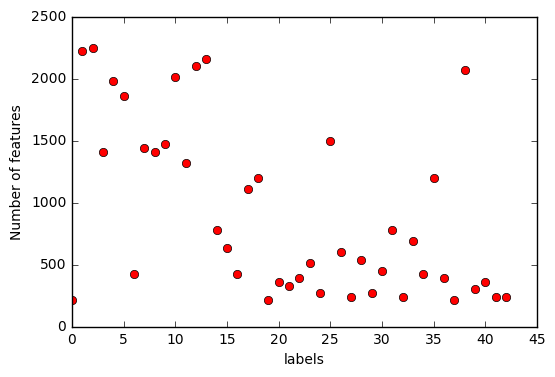

In [12]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt

labelDistribution = {}
for label in setOfLabels:
    for idx, val in enumerate(X_train):
        if original_y_train[idx] == label:
            if label in labelDistribution:
                labelDistribution[label] += 1
            else:
                labelDistribution[label] = 1

labelArray = []
featureCountByLabelArray = []
for key, value in labelDistribution.items():
    labelArray.append(key)
    featureCountByLabelArray.append(value)

plt.plot(labelArray,featureCountByLabelArray,'ro')
plt.ylabel('Number of features')
plt.xlabel('labels')

plt.show()

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [13]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
# Problem 1 - Implement Min-Max scaling for greyscale image data
def normalize_greyscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    output_array = []
    a = 0.1
    b = 0.9
    x_max = 255
    x_min = 0

#     return (image_data - X_train_mean)/x_max
#     return ((image_data - 128)/128)
    return  a+(((image_data - x_min)*(b - a))/(x_max - x_min)) 

# print(X_train[0])
# print(X_train[0][0])
X_train = np.mean(X_train, axis=3)
# print(X_train[0])
# print(X_train[0][0])
X_train = normalize_greyscale(X_train)
X_test = np.mean(X_test, axis=3)
X_test = normalize_greyscale(X_test)

In [14]:
fractionOfData = 0.05
roundedXTrainNumber = round(n_train*fractionOfData)
trainIdx = np.random.choice(X_train.shape[0], size=roundedXTrainNumber,replace=False)
roundedXTestNumber = round(n_test*fractionOfData)
testIdx = np.random.choice(X_test.shape[0], size=roundedXTestNumber,replace=False)

X_train = X_train[trainIdx, :]
y_train = y_train[trainIdx, :]
X_test = X_test[testIdx, :]
y_test = y_test[testIdx, :]

In [15]:
from sklearn.model_selection import train_test_split

# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    X_train,
    y_train,
    test_size=0.05,
    random_state=0)
print(len(train_features))
print(train_features[0])

1862
[[ 0.2296732   0.23281046  0.23385621 ...,  0.21398693  0.19620915
   0.18993464]
 [ 0.21712418  0.22026144  0.2296732  ...,  0.23490196  0.21084967
   0.18679739]
 [ 0.21921569  0.21084967  0.21607843 ...,  0.25686275  0.24431373
   0.1930719 ]
 ..., 
 [ 0.22339869  0.2275817   0.23490196 ...,  0.25581699  0.2296732
   0.22235294]
 [ 0.22130719  0.22862745  0.23281046 ...,  0.2579085   0.23385621
   0.2254902 ]
 [ 0.22339869  0.23281046  0.23071895 ...,  0.25163399  0.23281046
   0.22444444]]


In [18]:
import tensorflow as tf

features_count = 32*32*3
labels_count = 43

#Set the features and labels tensors
features = tf.placeholder(tf.float32)
labels = tf.placeholder(tf.float32)

# Problem 2 - Set the weights and biases tensors
weights = tf.Variable(tf.truncated_normal((features_count, labels_count)))
biases = tf.Variable(tf.zeros(labels_count))

In [19]:
# Feed dicts for training, validation, and test session#valid_feed_dict = {features: valid_features, labels: valid_labels}

train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}

# Linear Function WX + b
logits = tf.matmul(features, weights) + biases

prediction = tf.nn.softmax(logits)

# Cross entropy

cross_entropy = tf.reduce_mean(-tf.reduce_sum(
        labels * tf.log(tf.clip_by_value(prediction,1e-10,1.0)), reduction_indices=[1]))

# Training loss
loss = tf.reduce_mean(cross_entropy)

# Create an operation that initializes all variables
init = tf.initialize_all_variables()

In [20]:
# Determine if the predictions are correct
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))


Epoch  2/10:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.2993370592594147 Training accuracy at 0.31695660948753357



Epoch  2/10:  28%|██▊       | 516/1863 [00:01<00:18, 74.13batches/s]
Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda3/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Epoch  3/10:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.5782763957977295 Training accuracy at 0.5927029848098755


Epoch  4/10:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.6976032853126526 Training accuracy at 0.7309654355049133


Epoch  5/10:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.7399286031723022 Training accuracy at 0.7651954293251038


Epoch  6/10:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.7582865953445435 Training accuracy at 0.7855455279350281


Epoch  7/10:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.752167284488678 Training accuracy at 0.7818406224250793


Epoch  8/10:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.7735849022865295 Training accuracy at 0.8070500493049622


Epoch  9/10:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.781234085559845 Training accuracy at 0.8109428882598877


Epoch 10/10:   0%|          | 0/1863 [00:00<?, ?batches/s]

Validation accuracy at 0.8266190886497498 Training accuracy at 0.8531196117401123


Epoch 10/10: 100%|██████████| 1863/1863 [00:04<00:00, 411.86batches/s]


Validation accuracy at 0.8414074182510376 Training accuracy at 0.8693621158599854


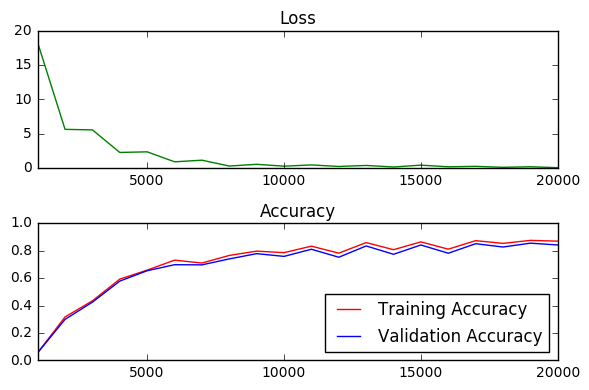

In [21]:
from tqdm import tqdm

import math
epochs = 10

batch_size = 20
learning_rate = .24
global batch_start
# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)    

# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
log_batch_step = 1000
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
#             print(batch_features.shape)
#             print(batch_features[0])
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run(
                [optimizer, loss],
                feed_dict={features: batch_features, labels: batch_labels})

            # Log every 50 batches
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)
        print('Validation accuracy at {}'.format(validation_accuracy),'Training accuracy at {}'.format(training_accuracy) )
        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [2]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [16]:
### Train your model here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
import time

# Parameters
learning_rate = 0.001
batch_size = 128 #43*30
training_epochs = 5 #5

n_input = 32*32  # MNIST data input (Shape: 28*28)
n_classes = 43  # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

layer_width = {
    'layer_1': 32,
    'layer_2': 64,
    'layer_3': 128,
    'fully_connected': 512
}

# Store layers weight & bias
weights = {
    'layer_1': tf.Variable(tf.truncated_normal(
        [5, 5, 1, layer_width['layer_1']],stddev=0.05)),
    'layer_2': tf.Variable(tf.truncated_normal(
        [5, 5, layer_width['layer_1'], layer_width['layer_2']],stddev=0.05)),
    'layer_3': tf.Variable(tf.truncated_normal(
        [5, 5, layer_width['layer_2'], layer_width['layer_3']],stddev=0.05)),
    'fully_connected': tf.Variable(tf.truncated_normal(
        [2048, layer_width['fully_connected']],stddev=0.05)),
    'out': tf.Variable(tf.truncated_normal(
        [layer_width['fully_connected'], n_classes],stddev=0.05))
}
# biases = {
#     'layer_1': tf.Variable(tf.zeros(layer_width['layer_1'])),
#     'layer_2': tf.Variable(tf.zeros(layer_width['layer_2'])),
#     'layer_3': tf.Variable(tf.zeros(layer_width['layer_3'])),
#     'fully_connected': tf.Variable(tf.zeros(layer_width['fully_connected'])),
#     'out': tf.Variable(tf.zeros(n_classes))
# }
biases = {
    'layer_1': tf.Variable(tf.truncated_normal(
            shape=[layer_width['layer_1']],stddev=0.05)),
    'layer_2': tf.Variable(tf.truncated_normal(
            shape=[layer_width['layer_2']],stddev=0.05)),
    'layer_3': tf.Variable(tf.truncated_normal(
            shape=[layer_width['layer_3']],stddev=0.05)),
    'fully_connected': tf.Variable(tf.truncated_normal(
            shape=[layer_width['fully_connected']],stddev=0.05)),
    'out': tf.Variable(tf.truncated_normal(
            shape=[n_classes],stddev=0.05))
}

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

# Create model
def conv_net(x, weights, biases):
#     x= tf.image.rgb_to_grayscale(x)
#     x = tf.reshape(x, shape=[-1, 32, 32, 3])

    # Layer 1
    conv1 = conv2d(x, weights['layer_1'], biases['layer_1'])
    conv1 = maxpool2d(conv1)

    # Layer 2
    conv2 = conv2d(conv1, weights['layer_2'], biases['layer_2'])
    conv2 = maxpool2d(conv2)

    # Layer 3
    conv3 = conv2d(conv2, weights['layer_3'], biases['layer_3'])
    conv3 = maxpool2d(conv3)

    # Fully connected layer
    # Reshape conv3 output to fit fully connected layer input
    fc1 = tf.reshape(
        conv3,
        [-1, weights['fully_connected'].get_shape().as_list()[0]])
    fc1 = tf.add(
        tf.matmul(fc1, weights['fully_connected']),
        biases['fully_connected'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output Layer - class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

# convenience next_batch function
def next_batch(x, y, batch_index, batch_size):
    start = batch_index + 1
    end = start + batch_size
    return x[start:end, :], y[start:end, :]
#     idx = np.arange(batch_size * batch_index,  min(len(x) - 1, batch_size * batch_index + batch_size))
#     return x[idx, :], y[idx,]

def LeNet(x):
    # Reshape from 2D to 4D. This prepares the data for
    # convolutional and pooling layers.
    x = tf.reshape(x, (-1, 32, 32, 1))
    # Squish values from 0-255 to 0-1.
#     x /= 255.
    # Resize to 32x32.
#     x = tf.image.resize_images(x, (32, 32))

    # TODO: Define the LeNet architecture.
    # Return the result of the last fully connected layer.
    return conv_net(x, weights, biases)


# tf Graph input
x = tf.placeholder("float", [None, 32 ,32])
y = tf.placeholder("float", [None, n_classes])
keep_prob = tf.placeholder("float") #dropout (keep probability)

# Create the LeNet.
fc2 = LeNet(x)

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(fc2, y))
opt = tf.train.AdamOptimizer()
train_op = opt.minimize(loss_op)
correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


def eval_data(dataset):
    """
    Given a dataset as input returns the loss and accuracy.
    """
    steps_per_epoch = dataset.num_examples // BATCH_SIZE
#     num_examples = steps_per_epoch * BATCH_SIZE
    total_acc, total_loss = 0, 0
    for step in range(steps_per_epoch):
        batch_x, batch_y = next_batch(X_train, y_train,batch_index,batch_size)
        loss, acc = sess.run([loss_op, accuracy_op], feed_dict={x: batch_x, y: batch_y})
        total_acc += (acc * batch_x.shape[0])
        total_loss += (loss * batch_x.shape[0])
        batch_index +=  batch_size
    return total_loss/steps_per_epoch, total_acc/steps_per_epoch

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
#     steps_per_epoch = mnist.train.num_examples // BATCH_SIZE
#     num_examples = steps_per_epoch * BATCH_SIZE

#     # Train model
#     for i in range(EPOCHS):
#         for step in range(steps_per_epoch):
#             batch_x, batch_y = mnist.train.next_batch(BATCH_SIZE)
#             loss = sess.run(train_op, feed_dict={x: batch_x, y: batch_y})

#         val_loss, val_acc = eval_data(mnist.validation)
#         print("EPOCH {} ...".format(i+1))
#         print("Validation loss = {}".format(val_loss))
#         print("Validation accuracy = {}".format(val_acc))

    # Training cycle
    for epoch in range(training_epochs):
        total_batches = int(n_train/batch_size)
        # Loop over all batches
        batch_index = 0
        for each_batch in range(total_batches):
            batch_x, batch_y = next_batch(X_train, y_train,batch_index,batch_size)
            print(batch_x[0][0][0])
            # Run optimization op (backprop) and cost op (to get loss value)
            loss = sess.run(train_op, feed_dict={x: batch_x, y: batch_y})
#             print(loss)
            batch_index +=  batch_size


#         val_loss, val_acc = eval_data({x: valid_features, y: valid_labels,
#                                        num_examples: len(valid_features)})
#         print("EPOCH {} ...".format(i+1))
#         print("Validation loss = {}".format(val_loss))
#         print("Validation accuracy = {}".format(val_acc))
        
    print("Optimization Finished!")

    # Evaluate on the test data
#     test_loss, test_acc = eval_data({x: X_test, y: y_test})
#     print("Test loss = {}".format(test_loss))
#     print("Test accuracy = {}".format(test_acc))

        
# logits = conv_net(x, weights, biases)

# # Define loss and optimizer
# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)\
#     .minimize(cost)
# # optimizer = tf.train.AdamOptimizer().minimize(cost)


# # Initializing the variables
# init = tf.initialize_all_variables()

# # # Launch the graph
# # with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
# #     sess.run(init)
# #     print("Optimization Started!")
# #     # Training cycle
# #     for epoch in range(training_epochs):
# #         total_batch = int(n_train/batch_size)
# #         # Loop over all batches
# #         batch_index = 0
# #         for i in range(total_batch):
# #             batch_x, batch_y = next_batch(X_train, y_train,batch_index,batch_size)
# #             batch_index +=  batch_size
# #             # Run optimization op (backprop) and cost op (to get loss value)
# #             sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
# #         # Display logs per epoch step
# #         c = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
# #         print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c),\
# #               "time Now:", time.strftime("%c"))
# #     print("Optimization Finished!")

# #     print("Test model Started!", time.strftime("%c"))
# #     # Test model
# #     correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
# #     print("Test accuracy Started!", time.strftime("%c"))
# #     # Calculate accuracy
# #     accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
# #     print(
# #         "Accuracy:",
# #         accuracy.eval({x: X_train, y: y_train}),time.strftime("%c"))

# # Launch the graph
# with tf.Session() as sess:
#     sess.run(init)
#     print("Optimization Started!")
#     # Training cycle
#     for epoch in range(training_epochs):
#         total_batch = int(n_train/batch_size)
#         # Loop over all batches
#         batch_index = 0
#         for i in range(total_batch):
#             batch_x, batch_y = next_batch(X_train, y_train,batch_index,batch_size)
#             batch_index +=  batch_size
#             # Run optimization op (backprop) and cost op (to get loss value)
#             sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
#         # Display logs per epoch step
#         c = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
#         print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c),\
#               "time Now:", time.strftime("%c"))
#     print("Optimization Finished!")

#     print("Test model Started!", time.strftime("%c"))
#     # Test model
#     correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
#     print("Test accuracy Started!", time.strftime("%c"))
#     # Calculate accuracy
#     accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
#     print(
#         "Accuracy:",
#         accuracy.eval({x: X_test, y: y_test}),time.strftime("%c"))


Tensor("strided_slice:0", shape=(32, 32, 1), dtype=float32)
[[ 0.31542484  0.57686275  0.37503268 ...,  0.56954248  0.81529412
   0.81424837]
 [ 0.28823529  0.2903268   0.54862745 ...,  0.32065359  0.65843137
   0.77346405]
 [ 0.3269281   0.28196078  0.40640523 ...,  0.28405229  0.50366013
   0.66052288]
 ..., 
 [ 0.23176471  0.20562092  0.28196078 ...,  0.28614379  0.47647059
   0.2945098 ]
 [ 0.26732026  0.21712418  0.23803922 ...,  0.35620915  0.30810458
   0.4179085 ]
 [ 0.23803922  0.21921569  0.24117647 ...,  0.30078431  0.28509804
   0.26313725]] [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]
[[ 0.15856209  0.17843137  0.22130719 ...,  0.1972549   0.19934641
   0.20562092]
 [ 0.16065359  0.17633987  0.22235294 ...,  0.20666667  0.20143791
   0.20248366]
 [ 0.16065359  0.17529412  0.20980392 ...,  0.20457516  0.19411765
   0.19620915]
 ..., 
 [ 0.188888

IndexError: index 0 is out of bounds for axis 0 with size 0

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [4]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.